# Quantum Machine Learning. Regressor

Quantum Machine Learning is one the the possible applications of Quantum Computing. This exercise is based on the paper [Mitarai K, Negoro M, Kitagawa M, Fujii K. Quantum circuit learning. Phys Rev A. 2018;98(3):032309.](https://arxiv.org/abs/1803.00745)

The example is inspired on [QCL page](http://dkopczyk.quantee.co.uk/qcl/), where a good description of the method is provided. However, to speedup the execution, instead the usual gradient descend algorithm for Machine Learning, a faster optimisation algorithm is used [Conjugate Gradient](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_cg.html)

The steps of the algorithm are:

1. Starting from state $|0\rangle$ and an case with input data ${x_i}$ of the dataset ($X$,$Y$), generate an initial Quantun State $|\Psi({x_i})>$ on the desired number of qubits (which can be larger than the number of input data for a single case). The amplitudes of this Quantum State are the input quantum features of the Machine Learning Model.
2. Apply $n$ times a combination of a random Time Evolution of one operator plus a set of parameterised rotations on each qubits.
3. Measure the expectation value of one operator of subset of Pauli operators $\{B_j\} \subset {\{I,X,Y,Z\}}^{\otimes N}$. This measurement will be the prediction $y_i$ for this input data ${x_i}$.
4. Minimize the cost function which compares the labels $Y$ with the predictions $y$.


Import the needed operations from ProjectQ

In [1]:
from projectq.cengines import MainEngine
from projectq.backends import Simulator
from projectq.ops import Z,X,H,Rx,Ry,Rz,All,Measure

Generate a dataset which follows the funcion $f(x)=x^2$ on the interval $[-1,1]$. This restriction on the input values does not limit the model, because in Classical Machine Learning, usually the input and output data are normalised as a first step.
Select the number of cases of the dataset assigning a value to P (take into account that a large number means long simulations)

In [2]:
import numpy as np
P=20
data_in=np.linspace(-1,1,P)
data_out=data_in*data_in

To inicialise the state (step 1), apply $R_z(cos^{-1}(x^2))R_y(sin^{-1}(x))$ to all qubits of the Quantum Register. Any other inicialisation is possible. If N i sthe number of qubits, the new state is:

$$|\Psi(x)>= (R_z(cos^{-1}(x^2))R_y(sin^{-1}(x))|0>)^{\otimes N}$$

In [3]:
def Uinit(qreg,x):
    import math
    theta_1=math.acos(x*x)
    theta_2=math.asin(x)
    All(Ry(theta_2)) | qreg
    All(Rz(theta_1)) | qreg


Create now the Unitary operation **U** to train. It receives as input the qubits in a Quantum Register (*qreg*) and an array with the parameters of the rotations which define this unitary operation.

For this case, to **each** qubit apply three rotations

$$R_x(\theta_{1j})R_z(\theta_{2j})R_x(\theta_{3j})$$ 

where $j$ is the index of the qubit. So, $\Theta =\{\theta_{ij}\}$ is an array of paramenters to train of dimensions $[3,N]$, where N is the number of qubits

In [4]:
def U(qreg,theta,d):
    for index,q in enumerate(qreg):
            Rx(theta[0,index,d]) | q
            Rz(theta[1,index,d]) | q
            Rx(theta[2,index,d]) | q

Before this Unitary operation, the state will evolve during a selected time **T** using a Hamiltonian which follows a fully connected transverse Isin model:

$$H = \sum_{j=1}^{N}\alpha_j X_j + \sum_{j=1}^{N}\sum_{k=1}^{j-1}J_{jk}Z_jZ_k$$

where $N$ is the number of qubits. 

In [5]:
from projectq.ops import QubitOperator

In [6]:
def Circuit_Hamiltonian(N,alpha,J):
    Hamiltonian=None
    k=0
    for j in range(N):
        if (Hamiltonian is None):
            Hamiltonian=alpha[j]*QubitOperator("X%d"%j)
        else:
            Hamiltonian=Hamiltonian+alpha[j]*QubitOperator("X%d"%j)

        for i in range(j):
            Hamiltonian=Hamiltonian+J[k]*QubitOperator("Z%d Z%d"%(j,i))
            k=k+1
    return Hamiltonian


In [7]:
from projectq.ops import TimeEvolution

Now it is time to compose the final circuit. The graphical representation of the circuit is:

<img src="Images/QCL.jpg" width="60%"/>

The function receives:
1. **x** that is the input data for this case
2. **Theta** a vector the dimension 3\*N\*D+1. Last element multiplies the expectation value before exit the function.
3. **N**, the number of qubits 
4. **D**, the number of times to repeat the evolution
5. **T**, the time to evolve th Hamiltonian
6. **H**, the Hamiltonian

The output must be the expectation value of $\sigma_z$ for qubit **0** multiplied by the parameter Theta\[-1\]

Hint: Use the ProjectQ methods:
1. [QubitOperator](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.QubitOperator)
2. [TimeEvolution](https://projectq.readthedocs.io/en/latest/projectq.ops.html#projectq.ops.TimeEvolution)
3. [get_expectation_value](https://projectq.readthedocs.io/en/latest/projectq.backends.html#projectq.backends.Simulator)

In [8]:
def qfun(x,Theta,N,D,T,H):
    theta1=Theta[0:3*N*D].reshape(3,N,D)

    eng=MainEngine(backend=Simulator(gate_fusion=True, rnd_seed=1000))
    qreg=eng.allocate_qureg(N)  
    
    Uinit(qreg,x)
    
    for i in range(D):
        TimeEvolution(time=T,hamiltonian=H) | qreg
        U(qreg,theta1,i)
    
    eng.flush()
    
    energy=eng.backend.get_expectation_value(QubitOperator("Z0"),[qreg[0]])
    
    All(Measure) | qreg
    eng.flush()
    del eng
    
    return Theta[-1]*energy
    

OK. Define the loss for the training:

$$loss = \frac{1}{m}\sum_{i=1}^m{(qfun(x_i)-y_i)}^2$$

where $m$ is the number of cases and $y_i$ is the label for case $i$

In [9]:
def loss(Theta,data_in,data_out,N,D,T,H):
    fun_out=0
    for i in range(len(data_in)):
        x=data_in[i]
        y=data_out[i]
        y_pred=qfun(x,Theta,N,D,T,H)
        fun_out+=(y_pred-y)**2
        
    return fun_out/len(data_in)

In [10]:
def jacobian(Theta,data_in,data_out,N,D,T,H):
    import random
    import math
    fun_out=np.zeros(len(data_in))
    for i in range(len(data_in)):
        x=data_in[i]
        y=data_out[i]
        y_pred=qfun(x,Theta,N,D,T,H)
        fun_out[i]=(y_pred-y)
    grad=np.zeros(len(Theta))
    for j in range(len(Theta)-1):
        grad[j]=0.
        for i in range(len(data_in)):
            x=data_in[i]
            Theta_in=Theta.copy()
            Theta_in[j]=Theta[j]+(math.pi*0.5)
            bplus=qfun(x,Theta_in,N,D,T,H)
            Theta_in[j]=Theta[j]-(math.pi*0.5)
            bminus=qfun(x,Theta_in,N,D,T,H)
            grad[j]+=(bplus-bminus)*fun_out[i]
    """
    The last weight is special, because it is not a rotation.
    """
    grad[-1]=0.
    for i in range(len(data_in)):
        x=data_in[i]
        grad[-1]+=2.*fun_out[i]*qfun(x,Theta,N,D,T,H)
    grad[-1]=grad[-1]/Theta[-1]
    grad=grad/len(data_in)
    return grad


Initialise the training parameters. The angles of the rotations must be selected randomly in the interval $[0,2\pi]$, meanwhile the factor of the expectation value is initialised to 1.0

Select also the number of repetitions (D) and the time for the Hamiltonian evolution (T)

**Hint**: if you want to speedup the convergence, use these pre-trained values for N=3, D=2 and T=10.

alpha= np.array([-0.09437294,  0.90506988, -0.67730307 ])

J= np.array([-0.62281193, -0.59477404, -0.24760364])

Theta= np.array([ 1.67414239, 5.81058199, 5.48748225,  4.76538875,  0.34889076,  5.14003758,
  6.46545405,  4.59147751,  4.80588215,  4.51748371,  3.73661614,  5.55503066,
  2.32459032,  1.04557867,  4.48241849,  5.51983066, -0.33860855,  5.99787863,
  2.00313909])

 and select the number of iterations to 10


In [11]:
N=3
D=2
T=10
alpha=(np.random.rand(N)-0.5)*2.0
J=(np.random.rand(N*(N-1)//2)-0.5)*2.0
Theta=np.random.rand(3*N*D+1)
Theta[0:3*N*D]=np.pi*2.*Theta[0:3*N*D]
Theta[-1]=1.0
"""
UNCOMMENT TO SPEEP-UP

alpha= np.array([ -0.09437294,  0.90506988, -0.67730307 ])
J= np.array([-0.62281193,-0.59477404, -0.24760364])
Theta= np.array([ 1.67414239, 5.81058199, 5.48748225,  4.76538875,  0.34889076,  5.14003758,
  6.46545405,  4.59147751,  4.80588215,  4.51748371,  3.73661614,  5.55503066,
  2.32459032,  1.04557867,  4.48241849,  5.51983066, -0.33860855,  5.99787863,
  2.00313909])
"""
Hamiltonian=Circuit_Hamiltonian(N,alpha,J)
print("The value of the initial loss is =",loss(Theta,data_in,data_out,N,D,T,Hamiltonian))

The value of the initial loss is = 0.5526696228023361


It is possible to check that the Jacobian is correct, comparing the result against the numerical gradient for the first point

In [12]:
grad=jacobian(Theta,data_in[0:1],data_out[0:1],N,D,T,Hamiltonian)
h=0.000001
for i in range(len(Theta)):
    Theta_in=Theta.copy()
    Theta_in[i]=Theta[i]+h
    h1=loss(Theta_in,data_in[0:1],data_out[0:1],N,D,T,Hamiltonian)
    Theta_in[i]=Theta[i]-h
    h2=loss(Theta_in,data_in[0:1],data_out[0:1],N,D,T,Hamiltonian)
    grad2=(h1-h2)/(2*h)
    print("Grad[%d]:%.5f - NumericalGrad[%d]:%.5f"%(i,grad[i],i,grad2))

Grad[0]:-0.10242 - NumericalGrad[0]:-0.10242
Grad[1]:1.81612 - NumericalGrad[1]:1.81612
Grad[2]:-0.21938 - NumericalGrad[2]:-0.21938
Grad[3]:-0.00000 - NumericalGrad[3]:0.00000
Grad[4]:0.19626 - NumericalGrad[4]:0.19626
Grad[5]:0.00000 - NumericalGrad[5]:0.00000
Grad[6]:1.58000 - NumericalGrad[6]:1.58000
Grad[7]:-0.30455 - NumericalGrad[7]:-0.30455
Grad[8]:0.22579 - NumericalGrad[8]:0.22579
Grad[9]:-0.00000 - NumericalGrad[9]:0.00000
Grad[10]:1.14640 - NumericalGrad[10]:1.14640
Grad[11]:0.00000 - NumericalGrad[11]:0.00000
Grad[12]:0.49247 - NumericalGrad[12]:0.49247
Grad[13]:-1.80939 - NumericalGrad[13]:-1.80939
Grad[14]:0.15287 - NumericalGrad[14]:0.15287
Grad[15]:0.00000 - NumericalGrad[15]:-0.00000
Grad[16]:-0.21963 - NumericalGrad[16]:-0.21963
Grad[17]:0.00000 - NumericalGrad[17]:0.00000
Grad[18]:0.92972 - NumericalGrad[18]:0.92972


Plot the initial form of the proposed function.

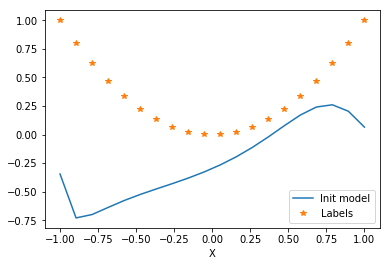

In [13]:
%matplotlib inline
import matplotlib.pyplot as plt
out=[qfun(j,Theta,N,D,T,Hamiltonian) for j in data_in]
plt.plot(data_in,out,label="Init model")
plt.xlabel("X")
plt.plot(data_in,data_out,"*",label="Labels")
plt.legend()
plt.show()

This is a callback function to show how the training evolves. **Just execute the next cell without changes**

In [14]:
def callback(xk):
    cost=loss(xk,data_in,data_out,N,D,T,Hamiltonian)
    out=[qfun(j,xk,N,D,T,Hamiltonian) for j in data_in]
    plt.plot(data_in,out,"b",label="Cost=%.4f"%cost)
    plt.plot(data_in,data_in*data_in,"*",label="Labels")
    out=[qfun(j,Theta,N,D,T,Hamiltonian) for j in data_in]
    plt.plot(data_in,out,"r",label="First")
    plt.xlabel("X")
    plt.legend()
    plt.show()
    print("Cost=",cost)
    print("Theta=",xk)
    return False

Ok. Now train the model. Select the number of iterations in maxiter

Use the minimize method with "Conjugate Gradient (CG)" as algorithm of minimisation. Do not forget to add the callback, so you can follow the training evolution.

**Hint**: [Minimize](https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize.html)

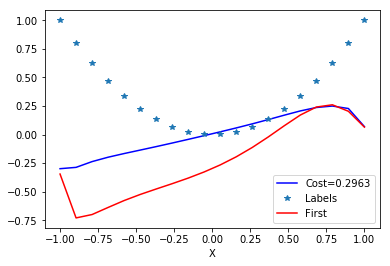

Cost= 0.29627350114173706
Theta= [1.1905981  5.18565151 5.21626529 4.76538875 1.0890606  5.14003758
 4.88400064 3.33873181 4.62866738 4.51748371 3.50553034 5.55503066
 1.13917282 0.8437952  3.21580754 5.51983066 0.13358033 5.99787863
 0.53348428]


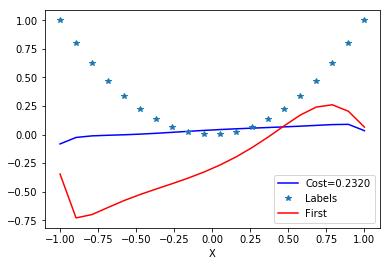

Cost= 0.23200021131265997
Theta= [1.2185832  5.37674618 5.2286394  4.76538875 0.97750107 5.14003758
 5.04822784 3.59586687 4.55379345 4.51748371 3.57186779 5.55503066
 1.20278748 0.69461104 3.23916211 5.51983066 0.20778544 5.99787863
 0.14661166]


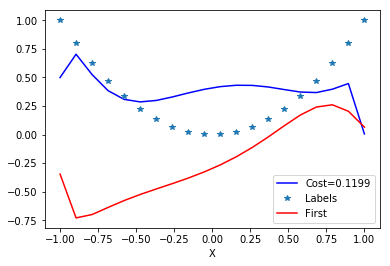

Cost= 0.11993116900775354
Theta= [1.13226023 6.19159087 5.32161992 4.76538875 0.61988038 5.14003758
 5.58802988 4.34795485 4.42720918 4.51748371 3.73653474 5.55503066
 1.43493508 0.12757493 3.36833697 5.51983066 0.39483738 5.99787863
 0.95469661]


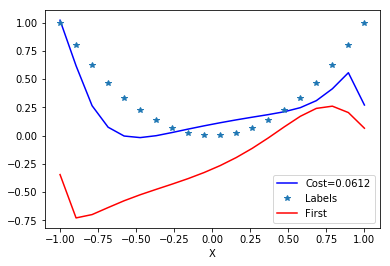

Cost= 0.061236358397674454
Theta= [1.19128833 6.51992199 5.53318958 4.76538875 0.56085933 5.14003758
 5.9668635  4.66018941 4.36276851 4.51748371 3.98003446 5.55503066
 1.66514449 0.16134973 3.47863006 5.51983066 0.35764772 5.99787863
 1.27311405]


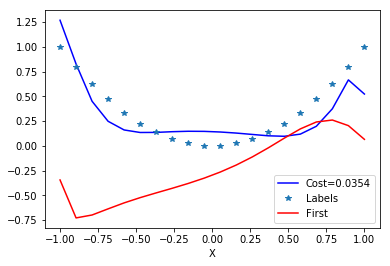

Cost= 0.03541029676388557
Theta= [1.0977846  6.35061942 5.62924832 4.76538875 0.60754807 5.14003758
 6.09309627 4.68691812 4.32151533 4.51748371 4.03050494 5.55503066
 1.62492041 0.36262448 3.51032601 5.51983066 0.27755598 5.99787863
 1.44954038]


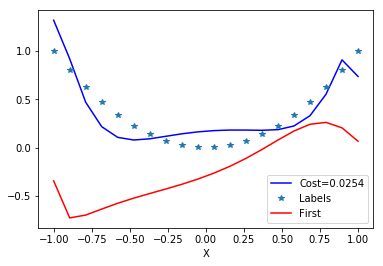

Cost= 0.025424439026512785
Theta= [1.18799144 6.15491615 5.72655796 4.76538875 0.62207998 5.14003758
 6.13888089 4.65319935 4.26011255 4.51748371 3.97202715 5.55503066
 1.73795455 0.36058879 3.50111092 5.51983066 0.24398088 5.99787863
 1.59260947]


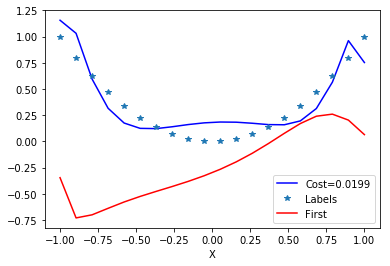

Cost= 0.01994245325525862
Theta= [1.18575502 5.99140652 5.85008272 4.76538875 0.6669036  5.14003758
 6.10712084 4.61516431 4.19840486 4.51748371 3.88920265 5.55503066
 1.7507016  0.41885006 3.54548905 5.51983066 0.12578804 5.99787863
 1.58402564]


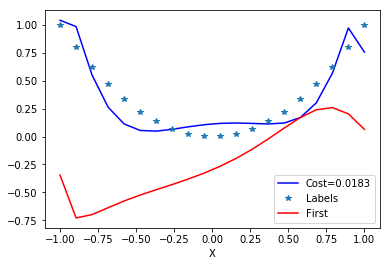

Cost= 0.018276980231511954
Theta= [1.20984934 5.94660459 5.91478955 4.76538875 0.70611419 5.14003758
 6.10780317 4.60954616 4.180352   4.51748371 3.8567277  5.55503066
 1.78323344 0.45959395 3.55957754 5.51983066 0.06199968 5.99787863
 1.56118954]


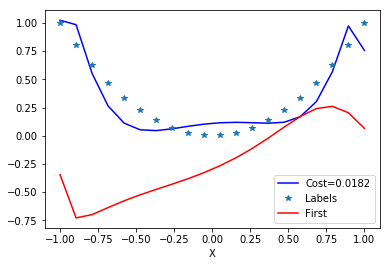

Cost= 0.018248240563137737
Theta= [1.21191617 5.93633243 5.92457287 4.76538875 0.70961233 5.14003758
 6.10627409 4.607114   4.17886169 4.51748371 3.84982583 5.55503066
 1.78655479 0.46527061 3.56361677 5.51983066 0.05275966 5.99787863
 1.55739953]


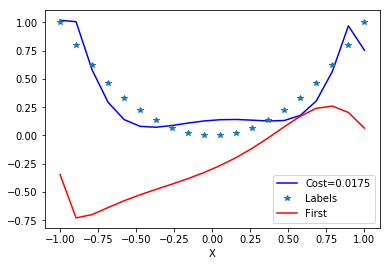

Cost= 0.017471625421628757
Theta= [1.20596516 5.92301644 5.92484544 4.76538875 0.70021567 5.14003758
 6.10027573 4.6011126  4.1833418  4.51748371 3.84266621 5.55503066
 1.7805198  0.46339726 3.57072924 5.51983066 0.05437969 5.99787863
 1.55668296]


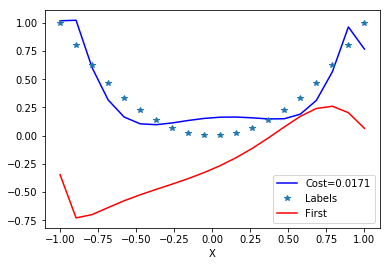

Cost= 0.017108031676114886
Theta= [1.20495018 5.90989131 5.92557554 4.76538875 0.68255127 5.14003758
 6.10080156 4.59467863 4.20621857 4.51748371 3.83061496 5.55503066
 1.78098894 0.46635797 3.58464366 5.51983066 0.05965409 5.99787863
 1.55205273]


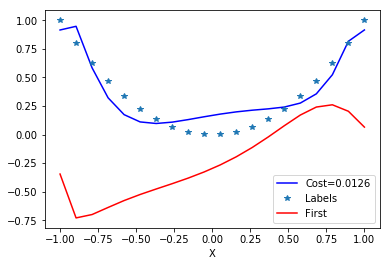

Cost= 0.012601659648471281
Theta= [1.30031105 5.82120313 5.99920841 4.76538875 0.5184432  5.14003758
 6.2138261  4.55921579 4.59425854 4.51748371 3.66782848 5.55503066
 1.91858443 0.61640897 3.77430247 5.51983066 0.07095658 5.99787863
 1.42945787]


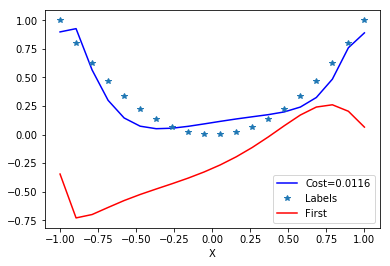

Cost= 0.01161727538109857
Theta= [1.32576828 5.82975825 6.02288551 4.76538875 0.50707327 5.14003758
 6.2383528  4.57352765 4.65353684 4.51748371 3.64039686 5.55503066
 1.95293447 0.67360464 3.80047742 5.51983066 0.0614637  5.99787863
 1.41390433]


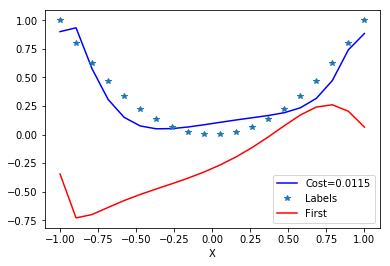

Cost= 0.011534764826596447
Theta= [1.33070413 5.82889418 6.02818991 4.76538875 0.49638591 5.14003758
 6.24379    4.57521638 4.67736901 4.51748371 3.63122439 5.55503066
 1.96098117 0.69166959 3.81235063 5.51983066 0.05868921 5.99787863
 1.41862607]


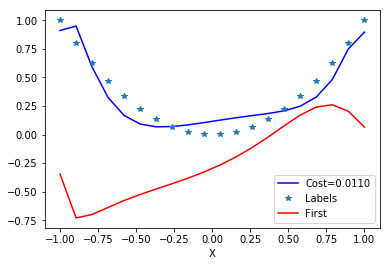

Cost= 0.01095388366831194
Theta= [1.32868708 5.82297301 6.02444276 4.76538875 0.48455687 5.14003758
 6.24075332 4.57004748 4.68655876 4.51748371 3.6300562  5.55503066
 1.9596025  0.6889676  3.81760459 5.51983066 0.05972512 5.99787863
 1.43222675]


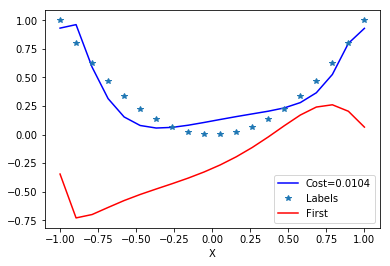

Cost= 0.010444466842585761
Theta= [1.33975478 5.82507872 6.01508653 4.76538875 0.469084   5.14003758
 6.23025154 4.57091409 4.68877673 4.51748371 3.63109687 5.55503066
 1.97092037 0.68146637 3.81370474 5.51983066 0.05942166 5.99787863
 1.47219462]


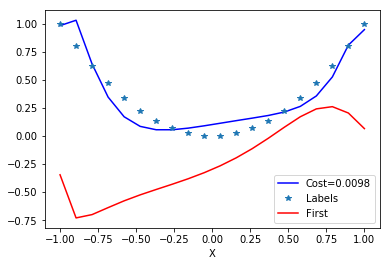

Cost= 0.009797987857145425
Theta= [1.33965135 5.83659412 6.00759946 4.76538875 0.45330729 5.14003758
 6.21524408 4.58428459 4.6968528  4.51748371 3.62936267 5.55503066
 1.97262579 0.71544937 3.82186003 5.51983066 0.04176542 5.99787863
 1.54277804]


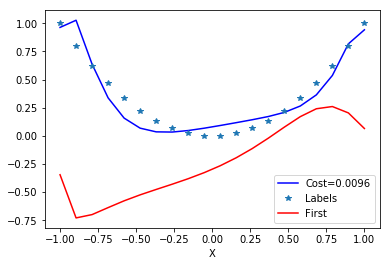

Cost= 0.009610607204310891
Theta= [1.35628809 5.8384781  5.99326345 4.76538875 0.45197694 5.14003758
 6.2046921  4.58707378 4.70971045 4.51748371 3.61773896 5.55503066
 1.99025234 0.72743459 3.8343095  5.51983066 0.01859409 5.99787863
 1.56063744]


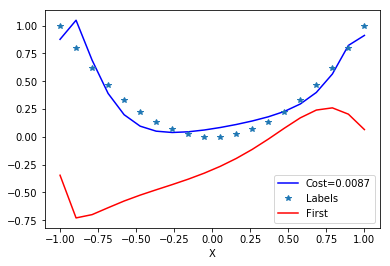

Cost= 0.008671017277978725
Theta= [ 1.40891881  5.81679641  5.9021564   4.76538875  0.42997858  5.14003758
  6.14948273  4.57140514  4.79186753  4.51748371  3.56292751  5.55503066
  2.04606909  0.77169102  3.92452341  5.51983066 -0.10183339  5.99787863
  1.6437908 ]


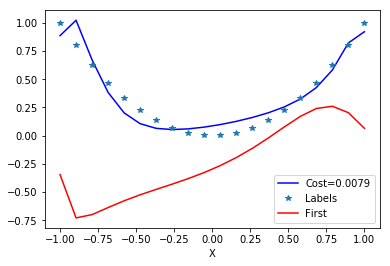

Cost= 0.007945944364077607
Theta= [ 1.4373091   5.81501761  5.83966686  4.76538875  0.41027549  5.14003758
  6.17791831  4.56980019  4.82806019  4.51748371  3.56200338  5.55503066
  2.07525359  0.77398765  3.98475098  5.51983066 -0.13434146  5.99787863
  1.66627992]


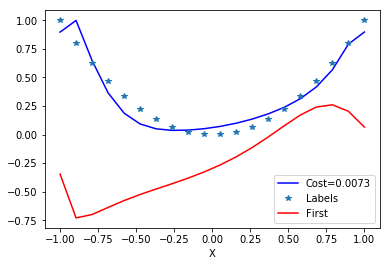

Cost= 0.007270668228209166
Theta= [ 1.46279059  5.82518015  5.79603572  4.76538875  0.40171107  5.14003758
  6.20954806  4.58229625  4.85398053  4.51748371  3.5585484   5.55503066
  2.10282798  0.79244103  4.03353396  5.51983066 -0.1605153   5.99787863
  1.68034478]


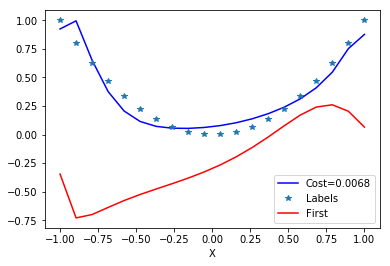

Cost= 0.006843657873160958
Theta= [ 1.47903311  5.82903761  5.74571201  4.76538875  0.38727707  5.14003758
  6.24668406  4.58832754  4.88088279  4.51748371  3.56306563  5.55503066
  2.1207743   0.81084434  4.0930491   5.51983066 -0.18510775  5.99787863
  1.70003102]


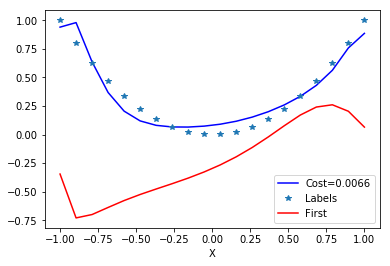

Cost= 0.006606643240577194
Theta= [ 1.49604824  5.82919588  5.71082629  4.76538875  0.37503018  5.14003758
  6.2719371   4.58851149  4.88985902  4.51748371  3.57313673  5.55503066
  2.13853888  0.81323529  4.12866078  5.51983066 -0.19680336  5.99787863
  1.71921846]


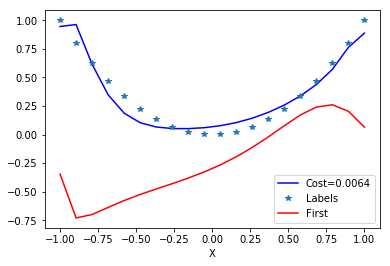

Cost= 0.00644910472818923
Theta= [ 1.51233244  5.83298001  5.6919681   4.76538875  0.3703321   5.14003758
  6.28815249  4.59327423  4.89027228  4.51748371  3.57979622  5.55503066
  2.1553173   0.82020266  4.14826693  5.51983066 -0.20447331  5.99787863
  1.73407974]


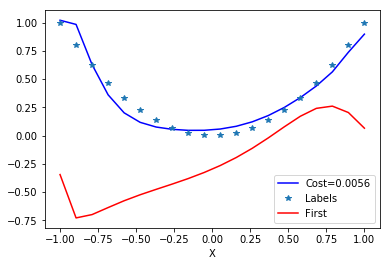

Cost= 0.005571662576425663
Theta= [ 1.57221343  5.83490888  5.5915025   4.76538875  0.34446494  5.14003758
  6.37508508  4.60527306  4.87187747  4.51748371  3.64418694  5.55503066
  2.21803754  0.90711457  4.28239607  5.51983066 -0.25278215  5.99787863
  1.85044119]


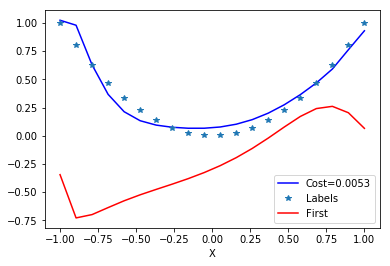

Cost= 0.005276419349436169
Theta= [ 1.595735    5.82625579  5.5588154   4.76538875  0.33821712  5.14003758
  6.40023653  4.59605642  4.85583527  4.51748371  3.67190692  5.55503066
  2.24381635  0.9268831   4.32975392  5.51983066 -0.27045915  5.99787863
  1.89081467]


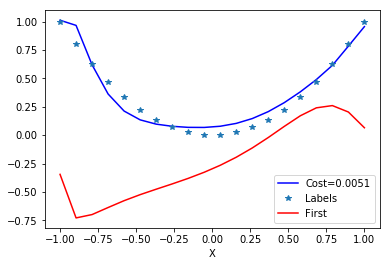

Cost= 0.005080245935560705
Theta= [ 1.62337859  5.81995228  5.52973047  4.76538875  0.33624393  5.14003758
  6.42431327  4.59078757  4.83831947  4.51748371  3.69699     5.55503066
  2.27334159  0.95176189  4.3760503   5.51983066 -0.28996276  5.99787863
  1.93002594]


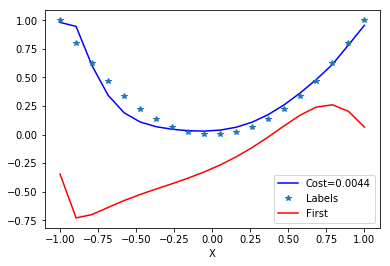

Cost= 0.004406630186738984
Theta= [ 1.65199428  5.81968168  5.51147539  4.76538875  0.34200704  5.14003758
  6.44321342  4.59592151  4.82338638  4.51748371  3.71248996  5.55503066
  2.30219773  0.98705691  4.41544498  5.51983066 -0.3100638   5.99787863
  1.96136508]


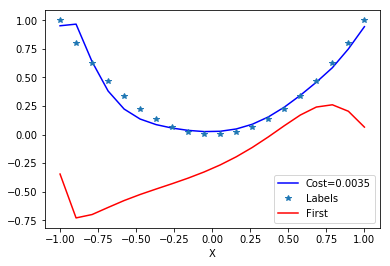

Cost= 0.003544916111725771
Theta= [ 1.67414239  5.81058199  5.48748225  4.76538875  0.34889076  5.14003758
  6.46545405  4.59147751  4.80588215  4.51748371  3.73661614  5.55503066
  2.32459032  1.04557867  4.48241849  5.51983066 -0.33860855  5.99787863
  2.00313909]


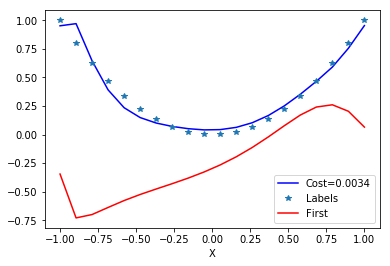

Cost= 0.0034190643200159134
Theta= [ 1.67452417  5.8073699   5.48482293  4.76538875  0.34841051  5.14003758
  6.46726534  4.5860292   4.80228706  4.51748371  3.7410317   5.55503066
  2.32576481  1.04652707  4.48928079  5.51983066 -0.33980203  5.99787863
  2.00692916]


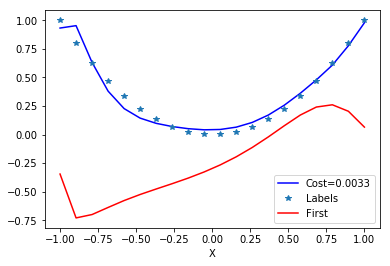

Cost= 0.003325146225159946
Theta= [ 1.68333893  5.80424735  5.48495254  4.76538875  0.35208134  5.14003758
  6.46988422  4.58088666  4.79022544  4.51748371  3.74662645  5.55503066
  2.33580836  1.04826159  4.49813453  5.51983066 -0.34024441  5.99787863
  2.01260168]


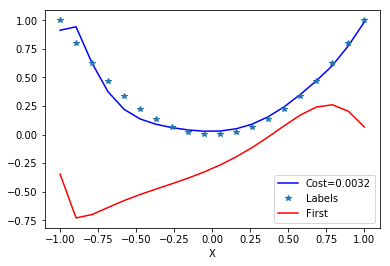

Cost= 0.0032496319277102287
Theta= [ 1.69091693  5.80249394  5.48817306  4.76538875  0.35780789  5.14003758
  6.47160385  4.58064619  4.77870896  4.51748371  3.74944117  5.55503066
  2.34323388  1.06090224  4.51059839  5.51983066 -0.33960233  5.99787863
  2.01818978]


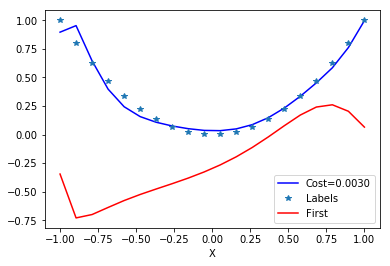

Cost= 0.0030297227682915557
Theta= [ 1.69652228  5.79491515  5.49191572  4.76538875  0.3652815   5.14003758
  6.47520806  4.57357545  4.75716066  4.51748371  3.75780362  5.55503066
  2.34858938  1.08936917  4.54302823  5.51983066 -0.33580153  5.99787863
  2.03086734]


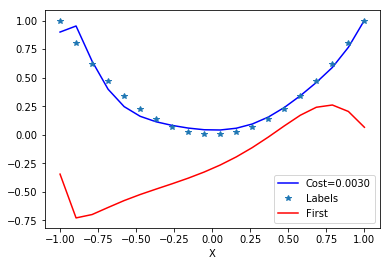

Cost= 0.0029971231169113694
Theta= [ 1.69701763  5.79420745  5.48999354  4.76538875  0.36368161  5.14003758
  6.47730663  4.57190603  4.75407985  4.51748371  3.75927799  5.55503066
  2.34930941  1.08825014  4.5455448   5.51983066 -0.33283864  5.99787863
  2.03311654]


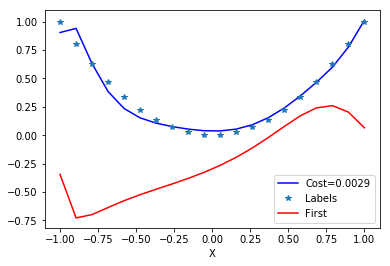

Cost= 0.002933649093759746
Theta= [ 1.70195646  5.79596265  5.48614367  4.76538875  0.36056617  5.14003758
  6.48332412  4.57520219  4.74699189  4.51748371  3.75931341  5.55503066
  2.35374528  1.087946    4.54852688  5.51983066 -0.32390305  5.99787863
  2.03836516]


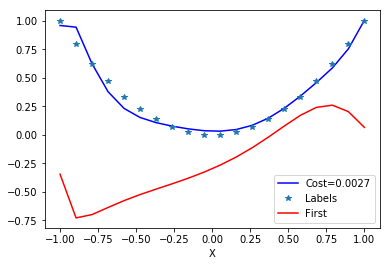

Cost= 0.002728914231450944
Theta= [ 1.70702292  5.80204795  5.46833853  4.76538875  0.34440301  5.14003758
  6.50594149  4.59109489  4.72996005  4.51748371  3.75480934  5.55503066
  2.35395448  1.10384481  4.56872542  5.51983066 -0.28643772  5.99787863
  2.05835703]


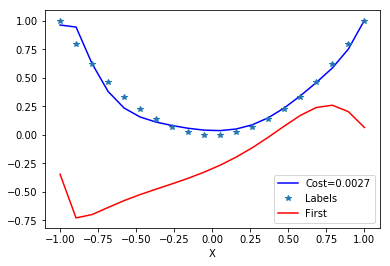

Cost= 0.0027118472831882505
Theta= [ 1.70700734  5.80151318  5.46597596  4.76538875  0.34313679  5.14003758
  6.50825304  4.59022009  4.72799905  4.51748371  3.75496599  5.55503066
  2.35368088  1.10468533  4.57169505  5.51983066 -0.28357449  5.99787863
  2.06027934]


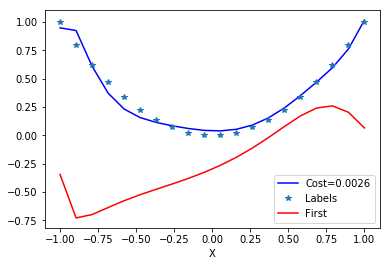

Cost= 0.0026057329586436583
Theta= [ 1.71966254  5.79700863  5.45457682  4.76538875  0.34775055  5.14003758
  6.52100087  4.58364195  4.71382543  4.51748371  3.75173112  5.55503066
  2.36384508  1.1148621   4.58762156  5.51983066 -0.27600333  5.99787863
  2.06899941]


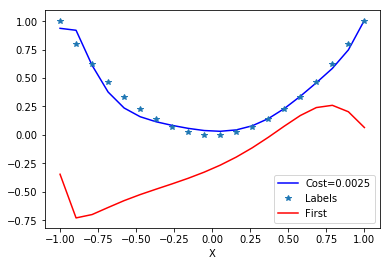

Cost= 0.002465934667246734
Theta= [ 1.72991206  5.79210994  5.44345907  4.76538875  0.35323525  5.14003758
  6.53102815  4.57899196  4.70380343  4.51748371  3.74674521  5.55503066
  2.36979266  1.13541166  4.60471997  5.51983066 -0.26981304  5.99787863
  2.07800666]
         Current function value: 0.002466
         Iterations: 40
         Function evaluations: 74
         Gradient evaluations: 74


In [15]:
from scipy.optimize import minimize
import math
options={'maxiter': 40, 'disp': True}
args=(data_in,data_out,N,D,T,Hamiltonian)
Theta_out=minimize(loss,Theta,args=args, jac=jacobian,callback=callback,method='CG', options=options)

Show the final results

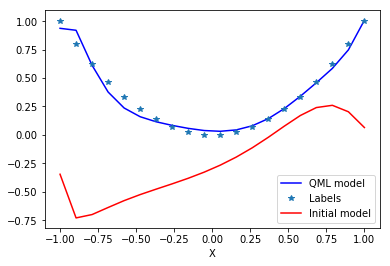

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt
#qfun(j,Theta,N,D,T)
out=[qfun(j,Theta_out.x,N,D,T,Hamiltonian) for j in data_in]
plt.plot(data_in,out,"b",label="QML model")
plt.plot(data_in,data_in*data_in,"*", label="Labels")
out=[qfun(j,Theta,N,D,T,Hamiltonian) for j in data_in]
plt.plot(data_in,out,"r",label="Initial model")
plt.legend()
plt.xlabel("X")
plt.show()

Remember to store all the parameters that define this model.

In [17]:
print("alpha=",alpha)

alpha= [-0.09437294  0.90506988 -0.67730307]


In [18]:
print("J=",J)

J= [-0.62281193 -0.59477404 -0.24760364]


In [19]:
print("Theta=",Theta_out.x)

Theta= [ 1.72991206  5.79210994  5.44345907  4.76538875  0.35323525  5.14003758
  6.53102815  4.57899196  4.70380343  4.51748371  3.74674521  5.55503066
  2.36979266  1.13541166  4.60471997  5.51983066 -0.26981304  5.99787863
  2.07800666]
